# Whistle Detection: Binary Classification

In this notebook, we'll directly train a network to detect dolphin whistles in a stream of audio. The anomaly detector represents a solution to the inverse problem, while this approach serves as a solution to the direct problem of classifying dolphin whistles. The organization is as follows:

1. Prepare a spectrogram-based dataset
2. Train a binary classification model to classify spectrograms as background or signal
3. Train a downstream binary classification model to label spectrograms as stranding events or nonstranding events
3. Run inference on a stream of audio
4. Extracting the detected dolphin whistles and classify them as stranding or nonstranding events.

We start with some usual imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import pathlib
from fastai2.vision.all import *
import tqdm
from IPython.display import Audio
from itertools import count

import scipy.signal
from scipy import interpolate
import soundfile as sf
import librosa
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier

import umap
import umap.plot

from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

Next, we define a number of constants that will be used in this notebook.

In [2]:
DATA = '../DataTableV1.csv'

SR = 72000
WINDOW_S = 1.0
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
DB_TH = 1e-4
RES = 64
FMAX = 20000
FMIN = 5000
MAX = 1
MIN = 0
POWER_FACTOR = 100000
WINDOW_WIDTH = int(WINDOW_S*SR)

LATENT_DIM = 256
DIMS = (RES,RES,1)

MEMBERS = 10
EPOCHS_REPEAT = 10
EPOCHS = 10
BATCH_SIZE = 16
VERBOSE = 1

NEIGHBORS = 10

# Preparing the Data

Now we are ready to load the data into training and testing subsets.

In [3]:
data_df = pd.read_csv(DATA)
detection_df = data_df[data_df.Detection!=0]
no_detection_df = data_df[data_df.Detection==0]

In [4]:
data_df.head()

Wav_Path  \
0  WHOIStrandingData/Pre-stranding acoustic files/03_18_17/806092826.170318051326.wav   
1  WHOIStrandingData/Pre-stranding acoustic files/03_18_17/806092826.170318051326.wav   
2  WHOIStrandingData/Pre-stranding acoustic files/03_18_17/806092826.170318051326.wav   
3  WHOIStrandingData/Pre-stranding acoustic files/03_18_17/806092826.170318051326.wav   
4  WHOIStrandingData/Pre-stranding acoustic files/03_18_17/806092826.170318051326.wav   

     Starts_s  Starts_f      Ends_s    Ends_f Call_Type   Alarm_Label  \
0  193.522646  13933630  194.273341  13987680     CT460  Prestranding   
1  195.350445  14065232  196.070888  14117103     CT458  Prestranding   
2  196.876558  14175112  198.219693  14271817     CT458  Prestranding   
3  210.590585  15162522  211.089354  15198433     CT458  Prestranding   
4  211.532703  15230354  211.939107  15259615     CT458  Prestranding   

   Detection  
0          1  
1          1  
2          1  
3          1  
4          1

In [4]:
def load_detection(data_table, row_index=0, window_length=None):
    start = data_table.Starts_s.iloc[row_index]
    end = data_table.Ends_s.iloc[row_index]
    
    if window_length is None:
        window_length = end - start
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length) 
    return wf

In [5]:
X1_audio = np.zeros((len(detection_df), int(SR*WINDOW_S)), dtype='float32')
Y1 = np.ones(X1_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(len(detection_df))):
    X1_audio[i] = load_detection(detection_df, row_index=i, window_length=WINDOW_S)

100%|██████████| 1239/1239 [00:21<00:00, 57.08it/s]


In [6]:
def load_no_detection(data_table, row_index=0, start=0, window_length=WINDOW_S):
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length)      
    return wf

In [7]:
np.random.seed(0)
neg_indices_wav = np.random.randint(low=0, high=len(no_detection_df), size=X1_audio.shape[0])
neg_starts = np.random.uniform(low=50, high=850, size=X1_audio.shape[0])
X0_audio = np.zeros_like(X1_audio, dtype='float32')
Y0 = np.zeros(X0_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(X1_audio.shape[0])):
    wav_idx = neg_indices_wav[i]
    start = neg_starts[i]
    try:
        X0_audio[i] = load_no_detection(no_detection_df, row_index=wav_idx, start=start)
    except:
        print(wav_idx, start)
        break

100%|██████████| 1239/1239 [01:25<00:00, 14.48it/s]


In [8]:
X, Y = np.vstack([X0_audio, X1_audio]), np.hstack([Y0, Y1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1982, 72000), (1982,), (496, 72000), (496,))

# Generating the Spectrogram Dataset

With our raw audio segments labeled according to whistle or background, we can now proceed to construct the spectrogram-based dataset. For this, we'll construct a custom spectrogram layer that we can build into the model.

In [9]:
class SpecGram(tf.keras.layers.Layer):    
    def __init__(self, 
                 name='spectrogram',
                 sr=SR, nfft=NFFT, 
                 hop_length=HOP_LENGTH, 
                 db_th=DB_TH, 
                 win=WINDOW, 
                 fmin=FMIN, 
                 fmax=FMAX, 
                 win_width=WINDOW_WIDTH,
                 **kwargs):
        super(SpecGram, self).__init__()
        self.sr = sr
        self.nfft = nfft
        
        if hop_length is None:
            self.hop_length = nfft // 16
        else:
            self.hop_length = hop_length
        
        self.db_th = db_th
        self.win = win
        
        if fmin is None:
            fmin = lambda f: np.min(f)
        else:
            self.fmin = fmin
        if fmax is None:
            self.fmax = lambda f: np.max(f)
        else:
            self.fmax = fmax
        if (fmin is not None) and (fmax is not None):
            self.f_conditions = lambda f: (f > fmin) & (f < fmax)
        else:
            self.f_conditions = lambda f: [True for _ in f]
            
        self.in_size = win_width
        self.out_size = self.compute_out_size()

    def call(self, x):
        return self.spectrogram_representation(x)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, 
                                  sr=self.sr, 
                                  nfft=self.nfft, 
                                  hoplength=self.hop_length, 
                                  win=self.win,
                                  db_th=self.db_th):
            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            #f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            #t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return spec_db

        def generate_representation(waveforms,
                                    sr=self.sr, 
                                    nfft=self.nfft, 
                                    hoplength=self.hop_length, 
                                    win=self.win,
                                    db_th=self.db_th):
            batch_size = waveforms.shape[0]
            reps = np.zeros((batch_size, self.out_size[0], self.out_size[1]))
            f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
            f_conditions = self.f_conditions(f_bins)
            for n in range(batch_size):
                Sxx = construct_spectrogram(waveforms[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                Sxx = Sxx[f_conditions]
                reps[n, :, :] = Sxx
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, self.out_size[0], self.out_size[1]))

    def compute_out_size(self):
        out_t = (self.in_size // self.hop_length) + 1
        f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
        f_conditions = self.f_conditions(f_bins)
        f_bins = f_bins[f_conditions]
        out_f = len(f_bins)
        return (out_f, out_t)
    
    def get_tf_bins(self):
        t_bins = np.linspace(0, self.in_size / self.sr, self.out_size[1])
        f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
        f_conditions = self.f_conditions(f_bins)
        f_bins = f_bins[f_conditions]
        return t_bins, f_bins

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))
    
        t,f = self.get_tf_bins()
        
        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].pcolormesh(t, f, reps[n, :, :], cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

Let's visualize the results.

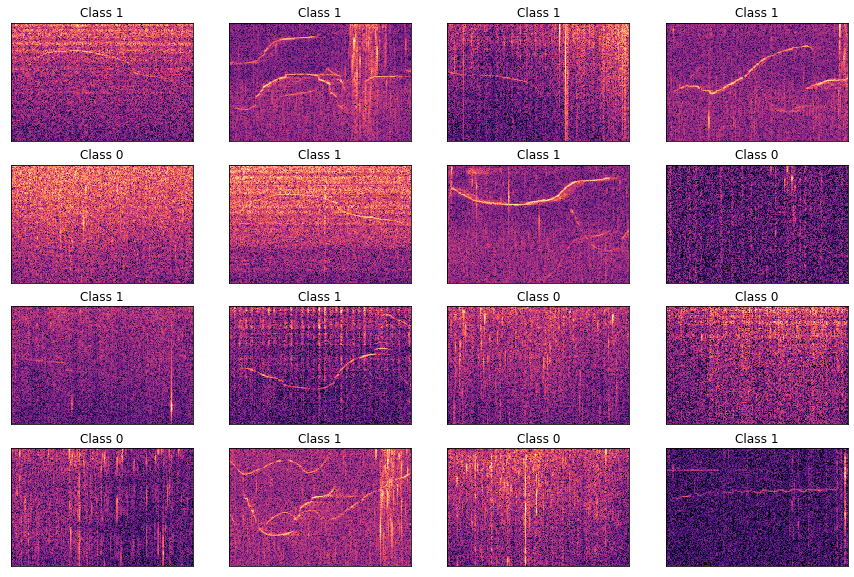

In [10]:
SpecGram().vis_rep(X_train[0:16], Y_train[0:16])

# Building the Model

We can proceed to construct the architecture. We will need a few ingredients in order to simplify the ML pipeline.

1. We define a MinMaxScaler layer to normalize the spectrogram features
2. We define a PowerNormalizer layer to further normalize the spectrogram features in order to ensure that the microphone receives the same amount of acoustic power per temporal window.
3. We build a network that integrates the spectrogram as a shallow layer in the architecture

In [11]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [12]:
class PowerNormalizer(tf.keras.layers.Layer):
    def __init__(self, name='normalizer_scaler', **kwargs):
        super(PowerNormalizer, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.normalizer(input_)

    @tf.function
    def normalizer(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)
        _sum = tf.math.reduce_sum(x, axis=2, keepdims=True)
        _sum = tf.math.reduce_sum(_sum, axis=1, keepdims=True)
        x_norm = tf.math.divide(x, _sum)
        x_norm = POWER_FACTOR * x_norm
        return x_norm

    def get_config(self):
        config = super(PowerNormalizer, self).get_config()
        return config

In [13]:
class SpecBuilder(tf.keras.Model):
    def __init__(self, window_width=WINDOW_WIDTH):
        super(SpecBuilder, self).__init__()
        self.window_width = window_width
        self.builder = self.build_spec_model()
        

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(self.window_width,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        x = PowerNormalizer()(x)
        outputs = tf.keras.layers.Reshape((SpecGram().out_size[0], SpecGram().out_size[1], 1), 
                                          input_shape=SpecGram().out_size)(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)
spec_builder = SpecBuilder().builder
spec_builder.summary()

Model: "spec_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72000)]           0         
_________________________________________________________________
spec_gram_1 (SpecGram)       (None, 213, 1126)         0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 213, 1126)         0         
_________________________________________________________________
normalizer_scaler (PowerNorm (None, 213, 1126)         0         
_________________________________________________________________
reshape (Reshape)            (None, 213, 1126, 1)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [14]:
def build_detection_classifier():
    inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
    x = SpecGram()(inputs)
    x = MinMaxScaler()(x)
    x = PowerNormalizer()(x)
    x = tf.keras.layers.Reshape((SpecGram().out_size[0], SpecGram().out_size[1], 1), 
                                      input_shape=SpecGram().out_size)(x)
    
    
    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(5, 5), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(7, 7), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='detection_classifier')
    return classifier

detection_model = build_detection_classifier()
detection_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                       metrics=['accuracy'])
detection_model.summary()

Model: "detection_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72000)]           0         
_________________________________________________________________
spec_gram_5 (SpecGram)       (None, 213, 1126)         0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 213, 1126)         0         
_________________________________________________________________
normalizer_scaler (PowerNorm (None, 213, 1126)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 213, 1126, 1)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 211, 1124, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 105, 562, 

# Training the Model

With our built model, we can train the model to classify the inputs as signal or background.

In [19]:
with tf.device('/GPU:0'):
    detection_model.fit(X_train, Y_train,
                     batch_size=BATCH_SIZE,
                     epochs=30,
                     validation_split=0.15,
                     verbose=1)

Epoch 1/30
106/106 [==============================] - 166s 2s/step - loss: 0.6955 - accuracy: 0.5101 - val_loss: 0.6924 - val_accuracy: 0.5738
Epoch 2/30
106/106 [==============================] - 164s 2s/step - loss: 0.6941 - accuracy: 0.5113 - val_loss: 0.6940 - val_accuracy: 0.4430
Epoch 3/30
106/106 [==============================] - 163s 2s/step - loss: 0.6843 - accuracy: 0.5825 - val_loss: 0.6240 - val_accuracy: 0.6779
Epoch 4/30
106/106 [==============================] - 165s 2s/step - loss: 0.3680 - accuracy: 0.8486 - val_loss: 0.2230 - val_accuracy: 0.9228
Epoch 5/30
106/106 [==============================] - 164s 2s/step - loss: 0.1922 - accuracy: 0.9341 - val_loss: 0.2287 - val_accuracy: 0.9396
Epoch 6/30
106/106 [==============================] - 164s 2s/step - loss: 0.1521 - accuracy: 0.9489 - val_loss: 0.1337 - val_accuracy: 0.9732
Epoch 7/30
106/106 [==============================] - 163s 2s/step - loss: 0.1261 - accuracy: 0.9525 - val_loss: 0.1155 - val_accuracy: 0.9698

In [32]:
detection_model.evaluate(X_test, Y_test)

16/16 [==============================] - 35s 2s/step - loss: 0.0696 - accuracy: 0.9798


[0.06960715353488922, 0.9798387289047241]

That looks promising! A training accuracy of 99.5%, a validation accuracy of 97.0%, and a testing accuracy of 98.0%. We are now ready to test the model on a stream of audio.

# Inference

It's not immediately intuitive that our model should be able to work well when asked to classify a stream of audio. To construct our training dataset, we selectively chose regions of the recordings that contain full dolphin whistles. Now, in order to generate inference data, we slide a window along the temporal axis and feed this input into the trained detector.

In [33]:
trained_detector=detection_model

In [34]:
def run_inference_on(wav, model, window_s=WINDOW_S, jump=1):
    wav = '../'+wav
    dur = sf.info(wav).duration
    win_starts = np.arange(0, int(dur-window_s) - 1, jump)
    wfs = []
    decisions = []
    for i in tqdm.tqdm(win_starts):
        wf_i, _ = librosa.load(wav, sr=None, offset=win_starts[i], duration=window_s)
        wf_i = np.expand_dims(wf_i, axis=0)
        pred = model(wf_i)
        pred_class = np.argmax(pred)
        if pred_class != 0:
            print(f'Step: {i}')
            print(f'     Prediction: {np.argmax(pred)}')
            print(f'     Confidence: {np.max(pred)} \n')
            spec_i = spec_builder(wf_i).numpy()
            plt.imshow(np.squeeze(spec_i), cmap='magma')
            plt.gca().invert_yaxis()
            plt.axis('off')
            plt.show()
        decisions.append(pred_class)
        wfs.append(wf_i)
    return wfs, decisions

  6%|▋         | 76/1198 [00:07<01:43, 10.84it/s]

Step: 76
     Prediction: 1
     Confidence: 0.9993422627449036 



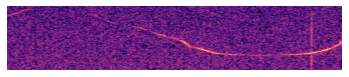

  7%|▋         | 78/1198 [00:07<02:09,  8.62it/s]

Step: 78
     Prediction: 1
     Confidence: 1.0 



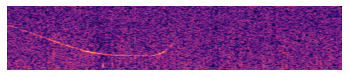

  7%|▋         | 81/1198 [00:07<02:30,  7.42it/s]

Step: 81
     Prediction: 1
     Confidence: 0.15976901352405548 



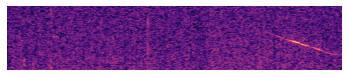

  7%|▋         | 82/1198 [00:08<03:06,  5.97it/s]

Step: 82
     Prediction: 1
     Confidence: 0.024190032854676247 



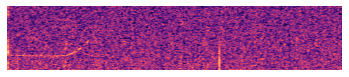

  8%|▊         | 96/1198 [00:09<01:50, 10.00it/s]

Step: 96
     Prediction: 1
     Confidence: 0.008304717019200325 



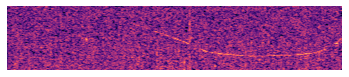

  8%|▊         | 98/1198 [00:09<02:13,  8.27it/s]

Step: 98
     Prediction: 1
     Confidence: 0.9978117346763611 



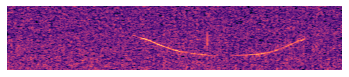

  9%|▉         | 109/1198 [00:11<01:53,  9.56it/s]

Step: 109
     Prediction: 1
     Confidence: 0.9461020231246948 



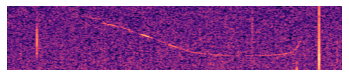

  9%|▉         | 111/1198 [00:11<02:26,  7.44it/s]

Step: 111
     Prediction: 1
     Confidence: 1.0 



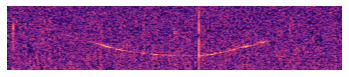

 10%|█         | 124/1198 [00:12<01:48,  9.91it/s]

Step: 124
     Prediction: 1
     Confidence: 0.002060642233118415 



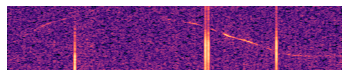

 11%|█         | 126/1198 [00:13<02:07,  8.43it/s]

Step: 126
     Prediction: 1
     Confidence: 0.9611386656761169 



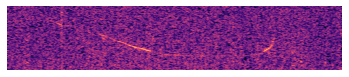

 11%|█         | 127/1198 [00:13<02:44,  6.50it/s]

Step: 128
     Prediction: 1
     Confidence: 0.9986507296562195 



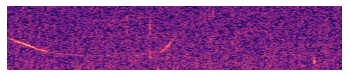

 11%|█         | 129/1198 [00:13<02:47,  6.38it/s]

Step: 129
     Prediction: 1
     Confidence: 0.011595848016440868 



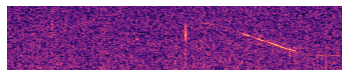

 12%|█▏        | 138/1198 [00:14<01:58,  8.95it/s]

Step: 139
     Prediction: 1
     Confidence: 1.0 



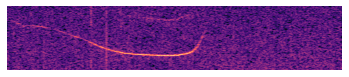

 12%|█▏        | 140/1198 [00:15<02:14,  7.87it/s]

Step: 140
     Prediction: 1
     Confidence: 0.0013934086309745908 



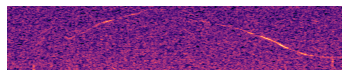

 12%|█▏        | 141/1198 [00:15<02:50,  6.21it/s]

Step: 142
     Prediction: 1
     Confidence: 0.9979034662246704 



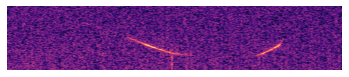

 13%|█▎        | 153/1198 [00:16<01:47,  9.70it/s]

Step: 154
     Prediction: 1
     Confidence: 0.004064013250172138 



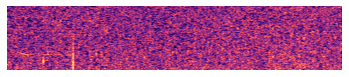

 13%|█▎        | 157/1198 [00:17<01:57,  8.85it/s]

Step: 157
     Prediction: 1
     Confidence: 0.8413445949554443 



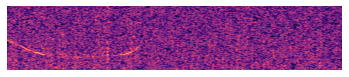

 14%|█▍        | 168/1198 [00:18<01:48,  9.48it/s]

Step: 168
     Prediction: 1
     Confidence: 0.05710538104176521 



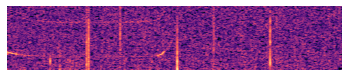

 14%|█▍        | 169/1198 [00:18<02:32,  6.73it/s]

Step: 170
     Prediction: 1
     Confidence: 0.9423602223396301 



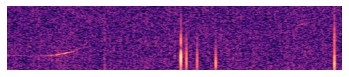

 14%|█▍        | 171/1198 [00:18<02:39,  6.43it/s]

Step: 171
     Prediction: 1
     Confidence: 0.9795706272125244 



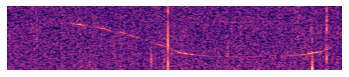

 16%|█▌        | 193/1198 [00:21<01:41,  9.90it/s]

Step: 193
     Prediction: 1
     Confidence: 0.0014619136927649379 



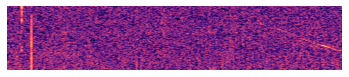

 16%|█▌        | 194/1198 [00:21<02:27,  6.80it/s]

Step: 195
     Prediction: 1
     Confidence: 0.023069705814123154 



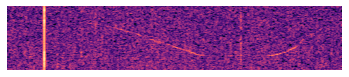

 16%|█▋        | 196/1198 [00:21<02:34,  6.48it/s]

Step: 197
     Prediction: 1
     Confidence: 0.9976638555526733 



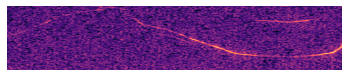

 17%|█▋        | 208/1198 [00:23<01:42,  9.67it/s]

Step: 209
     Prediction: 1
     Confidence: 0.0032011899165809155 



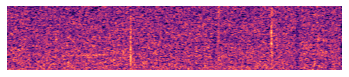

 18%|█▊        | 210/1198 [00:23<01:59,  8.24it/s]

Step: 210
     Prediction: 1
     Confidence: 0.002246369607746601 



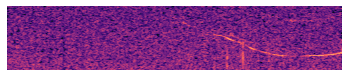

 18%|█▊        | 211/1198 [00:23<02:35,  6.37it/s]

Step: 211
     Prediction: 1
     Confidence: 0.9488246440887451 



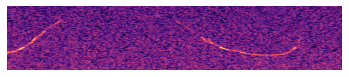

 18%|█▊        | 212/1198 [00:23<02:59,  5.49it/s]

Step: 212
     Prediction: 1
     Confidence: 0.16824215650558472 



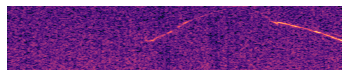

 18%|█▊        | 213/1198 [00:24<03:16,  5.02it/s]

Step: 213
     Prediction: 1
     Confidence: 1.0 



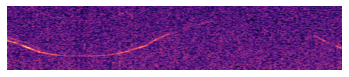

 19%|█▊        | 222/1198 [00:25<02:01,  8.02it/s]

Step: 222
     Prediction: 1
     Confidence: 0.9999998807907104 



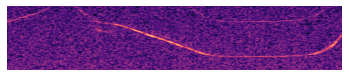

 19%|█▊        | 223/1198 [00:25<02:39,  6.11it/s]

Step: 224
     Prediction: 1
     Confidence: 1.0 



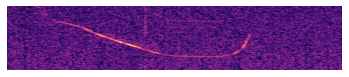

 19%|█▉        | 226/1198 [00:25<02:22,  6.80it/s]

Step: 226
     Prediction: 1
     Confidence: 1.0 



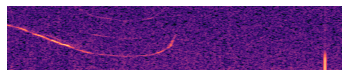

 19%|█▉        | 227/1198 [00:26<02:49,  5.73it/s]

Step: 227
     Prediction: 1
     Confidence: 0.48495689034461975 



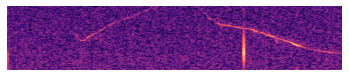

 19%|█▉        | 228/1198 [00:26<03:11,  5.07it/s]

Step: 228
     Prediction: 1
     Confidence: 0.07454674690961838 



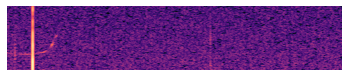

 20%|█▉        | 238/1198 [00:27<01:51,  8.58it/s]

Step: 239
     Prediction: 1
     Confidence: 1.0 



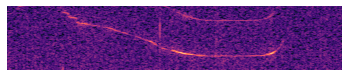

 20%|██        | 240/1198 [00:27<02:06,  7.56it/s]

Step: 241
     Prediction: 1
     Confidence: 1.0 



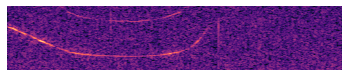

 22%|██▏       | 263/1198 [00:30<01:28, 10.61it/s]

Step: 264
     Prediction: 1
     Confidence: 0.7727804183959961 



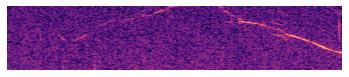

 22%|██▏       | 265/1198 [00:30<01:49,  8.54it/s]

Step: 265
     Prediction: 1
     Confidence: 1.0 



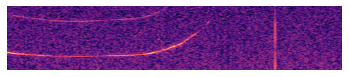

 22%|██▏       | 266/1198 [00:30<02:25,  6.39it/s]

Step: 266
     Prediction: 1
     Confidence: 0.84660804271698 



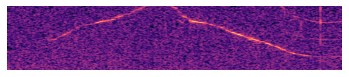

 22%|██▏       | 267/1198 [00:30<02:52,  5.39it/s]

Step: 267
     Prediction: 1
     Confidence: 1.0 



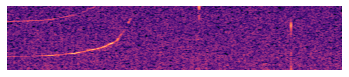

 22%|██▏       | 268/1198 [00:31<03:14,  4.79it/s]

Step: 268
     Prediction: 1
     Confidence: 0.2683372497558594 



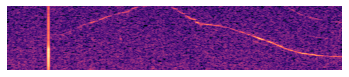

 22%|██▏       | 269/1198 [00:31<03:23,  4.55it/s]

Step: 269
     Prediction: 1
     Confidence: 0.6812222003936768 



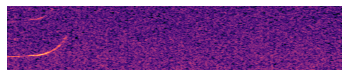

 23%|██▎       | 275/1198 [00:32<02:11,  7.02it/s]

Step: 276
     Prediction: 1
     Confidence: 0.9989903569221497 



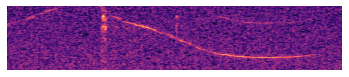

 24%|██▍       | 288/1198 [00:33<01:31,  9.94it/s]

Step: 289
     Prediction: 1
     Confidence: 0.001334506319835782 



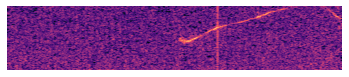

 24%|██▍       | 290/1198 [00:33<01:52,  8.08it/s]

Step: 290
     Prediction: 1
     Confidence: 1.0 



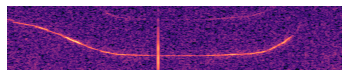

 24%|██▍       | 291/1198 [00:34<02:23,  6.33it/s]

Step: 291
     Prediction: 1
     Confidence: 0.9991642236709595 



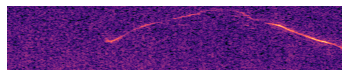

 24%|██▍       | 292/1198 [00:34<02:45,  5.48it/s]

Step: 292
     Prediction: 1
     Confidence: 1.0 



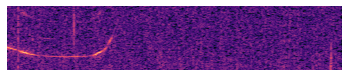

 25%|██▌       | 302/1198 [00:35<01:38,  9.11it/s]

Step: 302
     Prediction: 1
     Confidence: 1.0 



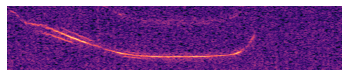

 25%|██▌       | 303/1198 [00:35<02:11,  6.79it/s]

Step: 303
     Prediction: 1
     Confidence: 0.957313597202301 



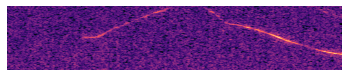

 25%|██▌       | 304/1198 [00:35<02:37,  5.69it/s]

Step: 304
     Prediction: 1
     Confidence: 0.9999998807907104 



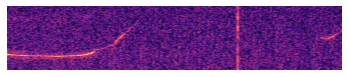

 25%|██▌       | 305/1198 [00:36<02:53,  5.14it/s]

Step: 305
     Prediction: 1
     Confidence: 0.9998413324356079 



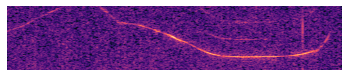

 26%|██▌       | 310/1198 [00:36<02:01,  7.28it/s]

Step: 311
     Prediction: 1
     Confidence: 0.945336639881134 



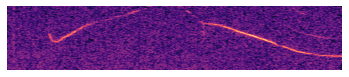

 26%|██▌       | 312/1198 [00:37<02:08,  6.89it/s]

Step: 312
     Prediction: 1
     Confidence: 0.9975360631942749 



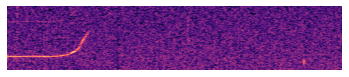

 26%|██▌       | 313/1198 [00:37<02:31,  5.85it/s]

Step: 313
     Prediction: 1
     Confidence: 0.9982187151908875 



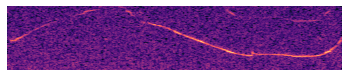

 26%|██▋       | 315/1198 [00:37<02:27,  5.99it/s]

Step: 315
     Prediction: 1
     Confidence: 1.0 



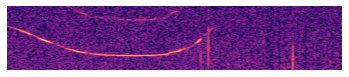

 27%|██▋       | 328/1198 [00:39<01:37,  8.90it/s]

Step: 328
     Prediction: 1
     Confidence: 1.0 



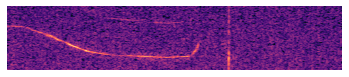

 27%|██▋       | 329/1198 [00:39<02:16,  6.39it/s]

Step: 329
     Prediction: 1
     Confidence: 0.8755112886428833 



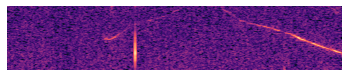

 28%|██▊       | 330/1198 [00:39<02:39,  5.45it/s]

Step: 330
     Prediction: 1
     Confidence: 1.0 



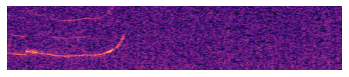

 28%|██▊       | 331/1198 [00:40<02:55,  4.95it/s]

Step: 331
     Prediction: 1
     Confidence: 0.23162804543972015 



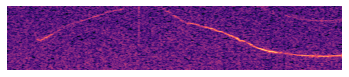

 28%|██▊       | 332/1198 [00:40<03:06,  4.65it/s]

Step: 332
     Prediction: 1
     Confidence: 0.021846529096364975 



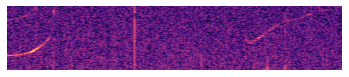

 28%|██▊       | 333/1198 [00:40<03:12,  4.49it/s]

Step: 333
     Prediction: 1
     Confidence: 1.0 



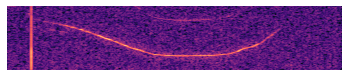

 29%|██▊       | 344/1198 [00:41<01:37,  8.79it/s]

Step: 344
     Prediction: 1
     Confidence: 0.010594003833830357 



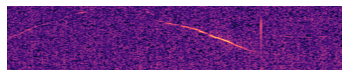

100%|██████████| 1198/1198 [02:03<00:00,  9.70it/s]


In [35]:
detections_wav = detection_df.Wav_Path.iloc[5]
waveforms, decisions = run_inference_on(detections_wav, trained_detector)

In [36]:
specs = []
for w in tqdm.tqdm(waveforms):
    _, _, spec = librosa.reassigned_spectrogram(y=w[0], sr=SR, n_fft=NFFT, hop_length=NFFT//16, window=WINDOW)
    spec_db = librosa.power_to_db(spec, amin=DB_TH)
    specs.append(spec_db)

100%|██████████| 1198/1198 [01:23<00:00, 14.33it/s]


In [63]:
np.save('Inference_Spectrograms.npy', specs)
np.save('Inference_Decisions.npy', decisions)

In [ ]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,6))

def frame_image(img, frame_width, color=-20):
    b = frame_width
    ny, nx = img.shape[0], img.shape[1]
    if img.ndim == 3:
        framed_img = color*np.ones((ny, nx, img.shape[2]))
    elif img.ndim == 2:
        framed_img = color*np.ones((ny, nx))
    framed_img[b:-b, b:-b] = img[b:ny-b, b:nx-b]
    return framed_img

def f(i):
    if decisions[i] != 1:
        img = spectrograms[i]
    else:
        img = frame_image(spectrograms[i], 30)
    return img
    
ims = []
for i in range(1, len(spectrograms)):
    im = plt.imshow(f(i), animated=True, cmap='magma', vmin=-40, vmax=-10)
    plt.gca().invert_yaxis()
    plt.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat=False)
writer = animation.FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save("Normalized_Detector_Animation.mp4", writer=writer)
HTML(ani.to_html5_video())

Finally, we'll load the inference animation:

In [1]:
from IPython.display import Video

Video("Normalized_Detector_Animation.mp4")